# Atividade 2

- **nome:** Jessé P. B. Rocha
- **R.A.:** 2149389

Esta atividade consiste na criação de um classificador *KNN* e um *SVM* para informar se um cogumelo é comestível ou venenoso.

# Importações e carregamento dos dados

In [82]:
import pandas as pd
import numpy as np 
import imblearn as ibl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from sklearn.svm import SVC
import itertools
from joblib import Parallel, delayed
from sklearn.metrics import f1_score, classification_report
from scipy.stats import ttest_ind_from_stats

%matplotlib inline

</br>

**Vamos** agora carregar a base de dados, separar em dados de entrada e de saída, e dar uma primeira olhada nele.

In [83]:
df = pd.read_csv("agaricus_lepiota_small_c.csv")
y = df[["class"]]
X = df.drop(["class"], axis=1)
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,e,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,e,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,e,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,p,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,p,x,f,p,f,c,f,w,n,n,...,s,w,w,p,w,o,p,n,v,d
996,p,x,y,n,f,n,f,c,n,w,...,y,w,y,p,w,o,e,w,v,d
997,e,x,f,g,f,n,f,c,b,u,...,s,g,g,p,w,o,e,k,y,d
998,e,b,s,w,t,a,f,c,b,b,...,s,g,w,p,w,o,p,h,y,p


**Temos**, como exibido, mil registros e 23 colunas. É importante perceber também que o atributo de saída *class* é categórico. Isso pode ser um pouco complicado para o uso da métrica *f1 score*, que será usada nessa atividade. Logo, vamos codificá-lo, fazendo com que 0 = "e" e 1 = "p".

In [84]:
transformers = [
    ("oe_class", OrdinalEncoder(), ["class"])
]

ct = ColumnTransformer(transformers, remainder="passthrough")
y_oe = ct.fit_transform(y)
y = y_oe.ravel()
y

array([0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 1.

# Tratando dados faltantes

Verifiquemos agora a existência de dados faltantes e quais atributos possuem dados faltantes.

In [85]:
X.isnull().sum()

cap-shape                     0
cap-surface                   0
cap-color                     0
bruises                       0
odor                          0
gill-attachment               0
gill-spacing                  0
gill-size                     0
gill-color                    0
stalk-shape                   0
stalk-root                  310
stalk-surface-above-ring      0
stalk-surface-below-ring      0
stalk-color-above-ring        0
stalk-color-below-ring        0
veil-type                     0
veil-color                    0
ring-number                   0
ring-type                     0
spore-print-color             0
population                    0
habitat                       0
dtype: int64

</br>

**Perceba** que só há dados faltantes no atributo *stalk-root*. Perceba também que, dos 1000 registros, 310 possuem esse dado como faltante. Não iremos remover esse atributo, pois a raíz do caule pode ser interessante de usar no classificador. Logo, faremos a imputação. Para tentar manter a proporção da base de dados, faremos a imputação pelo valor mais frequente.

In [86]:
stalk = ["stalk-root"]
rest_of_df = ["cap-shape",
              "cap-surface",
              "cap-color",
              "bruises",
              "odor",
              "gill-attachment",
              "gill-spacing",
              "gill-size",
              "gill-color",
              "stalk-shape",
              "stalk-surface-above-ring",
              "stalk-surface-below-ring",
              "stalk-color-above-ring",
              "stalk-color-below-ring",
              "veil-type",
              "veil-color",
              "ring-number",
              "ring-type",
              "spore-print-color",
              "population",
              "habitat"]

transformers = [
    ('imp_stalk_root', SimpleImputer(strategy="most_frequent"), stalk),
]

ct_imp = ColumnTransformer(transformers, remainder="passthrough")
X_imputed_values = ct_imp.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed_values, columns=[*stalk, *rest_of_df])
X_imputed

,stalk-root,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,b,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,e,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,b,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,b,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,e,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b,x,f,p,f,c,f,w,n,n,...,s,w,w,p,w,o,p,n,v,d
996,b,x,y,n,f,n,f,c,n,w,...,y,w,y,p,w,o,e,w,v,d
997,b,x,f,g,f,n,f,c,b,u,...,s,g,g,p,w,o,e,k,y,d
998,b,b,s,w,t,a,f,c,b,b,...,s,g,w,p,w,o,p,h,y,p


</br>

**Vejamos** agora se nossa imputação está correta, conferindo novamente se há dados faltantes

In [87]:
X_imputed.isnull().sum().sum()

0

# Codificação dos dados categóricos

Agora que não temos mais dados faltantes em nossa base de dados, vamos realizar a codificação dos dados categóricos. Perceba que o dataset inteiro é formado por dados desse tipo. Assim sendo, teremos que realizar a codificação de todos eles.

Perceba ainda, que temos dois atributos que aparentam ter o atributo ordinal, a saber, *bruises* e *ring-number*. O primeiro, indica a existência (ou não), de contusões. Já o segundo indica a quantidade de anéis no cogumelo. Portanto eles serão codificados usando o *ordinal encoder*.

In [88]:
atributos_ordinais = ["bruises", "ring-number"]
atributos_nominais = ["cap-shape",
                      "cap-surface",
                      "cap-color",
                      "odor",
                      "gill-attachment",
                      "gill-spacing",
                      "gill-size",
                      "gill-color",
                      "stalk-shape",
                      "stalk-root",
                      "stalk-surface-above-ring",
                      "stalk-surface-below-ring",
                      "stalk-color-above-ring",
                      "stalk-color-below-ring",
                      "veil-type",
                      "veil-color",
                      "ring-type",
                      "spore-print-color",
                      "population",
                      "habitat"]

transformers = [
    ("od_atribs_ordinais", OrdinalEncoder(), atributos_ordinais),
    ("oh_atribs_nominais", OneHotEncoder(), atributos_nominais)
]

ct_od_oh = ColumnTransformer(
    transformers, remainder="passthrough"
)

X_od_oh = ct_od_oh.fit_transform(X_imputed).todense()

</br>

**Vejamos** o resultado da nossa codificação.

In [89]:
X_od_oh

matrix([[1., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]])

# Exploração dos dados

Vamos agora explorar os dados do nosso dataset para conhecê-lo um pouco melhor. Mas antes, precisamos normalizar os dados para termos uma melhor visualização.

In [90]:
ss = StandardScaler()
ss.fit(X_od_oh)
X_ss = ss.transform(X_od_oh) 

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


</br>

**Agora** sim podemos plotar os dados utilizando a técnica *PCA*.

<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

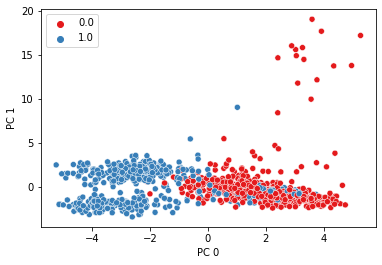

In [99]:
pca_ss = PCA(n_components=2)
pca_ss.fit(X_ss)
X_ss_pca = pca_ss.transform(X_ss)
X_ss_pca_df = pd.DataFrame(X_ss_pca, columns=['PC 0', 'PC 1'])
sns.set_palette('seismic')
sns.scatterplot(data=X_ss_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

</br>

**Perceba** que há alguns *out liners*, mas ainda assim, os dados estão consideravelmente bem separados. Provavelmente, o *KNN* conseguirá se sair bem na classificação.


# Classificadores

Vamos agora construir os classificadores que serão utilizados nessa atividade, a saber, o *KNN* e o *SVM*. Nos dois casos, usaremos a validação cruzada em dois níveis.

## KNN

In [52]:
def executa_cvd_knn(X, y, cv_splits, ks, n_jobs=8, range_option=range(1, 30, 2)):    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)
    f1s_knn = []
    class_report_knn = []

    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for idx_treino, idx_teste in skf.split(X, y):
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]

        X_teste = X[idx_teste]
        y_teste = y[idx_teste]

        X_treino, X_val, y_treino, y_val = train_test_split(
            X_treino,
            y_treino,
            stratify=y_treino,
            test_size=0.2,
            random_state=1
        )

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        combinacoes = {'n_neighbors': range_option}
        score = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'

        knn = KNeighborsClassifier()
        knn = GridSearchCV(knn, combinacoes, cv=StratifiedKFold(n_splits=5), n_jobs=n_jobs, scoring=score)
        knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        pred = knn.predict(X_teste)

        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s_knn.append(f1)
        class_report_knn.append(classification_report(y_teste, pred))
        
        pgb.update(1)
    pgb.close()
    
    return f1s_knn, class_report_knn, knn

## SVM

In [53]:
def executa_cvd_svm(X, y, cv_splits, params, n_jobs=8):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)
    f1s_svm = []
    class_report_svm = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for idx_treino, idx_teste in skf.split(X, y):
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]
        
        X_teste = X[idx_teste]
        y_teste = y[idx_teste]
        
        X_treino, X_val, y_treino, y_val = train_test_split(
            X_treino,
            y_treino,
            stratify=y_treino,
            test_size=0.2,
            random_state=1
        )
        
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)
        
        score = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        svm = GridSearchCV(SVC(), param_grid=params, cv=StratifiedKFold(n_splits=5), n_jobs=n_jobs, scoring=score)
        svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        pred = svm.predict(X_teste)
        
        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s_svm.append(f1)
        class_report_svm.append(classification_report(y_teste, pred))
        
        pgb.update(1)
    pgb.close()
    
    return f1s_svm, class_report_svm, svm

</br>

**Implementada** a validação cruzada em dois níveis com os classificadores solicitados, vamos agora obter os resultados para avaliá-los.

In [54]:
f1s_knn, class_report_knn, knn = executa_cvd_knn(X_od_oh, y, 10, range(1, 30, 2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/hom

In [55]:
f1s_svm, class_report_svm, svm = executa_cvd_svm(X_od_oh,
                                                 y,
                                                 10,
                                                 params={'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']})

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jessepbr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/hom

In [56]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

</br>

**Vejamos** os resultados obtidos.

In [57]:
imprimir_estatisticas(f1s_knn)
imprimir_estatisticas(f1s_svm)

Resultados: 0.96 +- 0.01, min: 0.94, max: 0.98
Resultados: 0.95 +- 0.02, min: 0.93, max: 0.98


</br>

**Perceba** que, mesmo que diferença seja bem pequena, o *KNN* ainda se saiu melhor que o *SVM*. Mas será que essa diferença é estatisticamente significativa?

# Teste da Hipótese Nula

Vamos utilizar o Teste T de Student para fazer o teste da hipótese nula. Assim, poderemos responder nossa pergunta anterior.

In [100]:
def rejeitar_hipotese_nula(amostra1, amostra2, alpha=0.5):
    media_amostral1, desvio_padrao_amostral1, _, _ = calcular_estatisticas(amostra1)
    media_amostral2, desvio_padrao_amostral2, _, _ = calcular_estatisticas(amostra2)
    
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, len(amostra1), media_amostral2, desvio_padrao_amostral2, len(amostra2))
    resultado = pvalor <= alpha
    return resultado, pvalor

In [103]:
resultado, pvalor = rejeitar_hipotese_nula(f1s_knn, f1s_svm, alpha=0.05)

print('resultado: ', resultado)
print('pvalor: ', pvalor)

resultado:  False
pvalor:  0.4518409223820894


</br>

**Perceba** que o resultado da função que rejeita hipótese nula foi *False*. Isso significa que, com 95% de confiança, os dois modelos, um usando o *KNN* e o outro usando o *SVM*, não possuem diferença estatisticamente significante. Isso pode ser visto pelo pvalor retornado que é maior 0.05. Ou seja, por mais que, em valores absolutos, haja diferença, na prática ela não possui efeito significativo.

# Você usaria seu classificador?

Com base nos resultados, no que diz respeito a escolher um dos classificadores, qualquer um dois poderia ser escolhido, já que não são estatisticamente, diferentes. Já no que diz respeito ao desempenho, eles se demonstraram confiáveis até certo nível, chegando um tanto perto dos 100% de acerto e com um desvio padrão baixo.

Assim sendo, eu usaria, mas não o teria como única fonte de informação. Ainda ficaria um pouco desconfiado já que estamos falando de algo que pode matar. Mas ainda assim, o usaria para ajudar na decisão.